In [1]:
import numpy as np
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
%load_ext autoreload
%autoreload 2

In [2]:
from utils import MyDataLoader
DL = MyDataLoader()
DL.read_gt("data/clusters.csv")
DL.data.head(10)

INFO:root:Loaded 1521 images


,cluster_id,file_name,cluster_num
0,5f1f5a4cb43b4a13b1f281d951ed7517,a00ee19f8bdd48a3af5ff78789887ad1.jpg,354
1,5f1f5a4cb43b4a13b1f281d951ed7517,9a34cabc4be94126a958267e2e3d1676.jpg,354
2,5f1f5a4cb43b4a13b1f281d951ed7517,381529cfa29942f3a30cb35247ff1c63.jpg,354
3,5f1f5a4cb43b4a13b1f281d951ed7517,c646ed62b45145c682733cfce9c815d7.jpg,354
4,5f1f5a4cb43b4a13b1f281d951ed7517,6a5d90d13fdc47348753144d5a33be71.jpg,354
5,5f1f5a4cb43b4a13b1f281d951ed7517,8da290af60ab462c911aaa603824fd52.jpg,354
6,5f1f5a4cb43b4a13b1f281d951ed7517,1a6f1972db7e41fdb731bd47433e2090.jpg,354
7,5f1f5a4cb43b4a13b1f281d951ed7517,3e7a3af1e0644d9bb417f0b051a8e0ec.jpg,354
8,5f1f5a4cb43b4a13b1f281d951ed7517,9ef20db40f2f4cc79efeb76ef5562cf0.jpg,354
9,5f1f5a4cb43b4a13b1f281d951ed7517,af1c87f519f2493980cbcd9cc11f5eb6.jpg,354


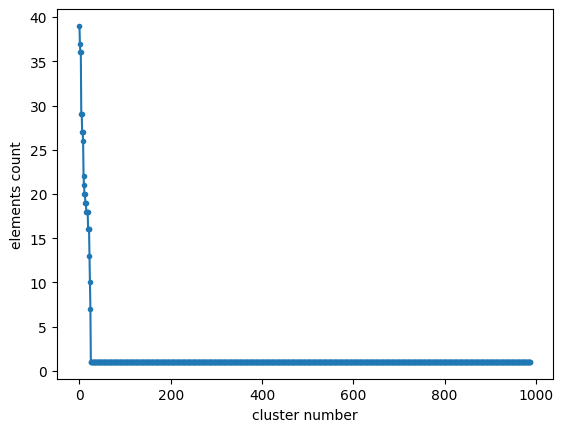

In [3]:
DL.show_stats()

In [7]:
DL.read_encodings("encodings.json")

INFO:root:Loaded 1521 encodings


In [8]:
from clusterization import MyClusterUsers
clust = MyClusterUsers(DL)
clust.fit(min_samples_range=range(2, 10), 
          eps_range=np.arange(0.2, 1., 0.2))

INFO:root:Sync images with faces. Encodings x: (596, 128), labeled clusters y:(596,)
INFO:root:Best silhouette_score: 0.4261512148943709
INFO:root:min_samples: 2
INFO:root:eps: 0.4
INFO:root:Unique faces: 25


In [9]:
clust.validate()

INFO:root:V-score: 0.94


0.9376759595461605

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


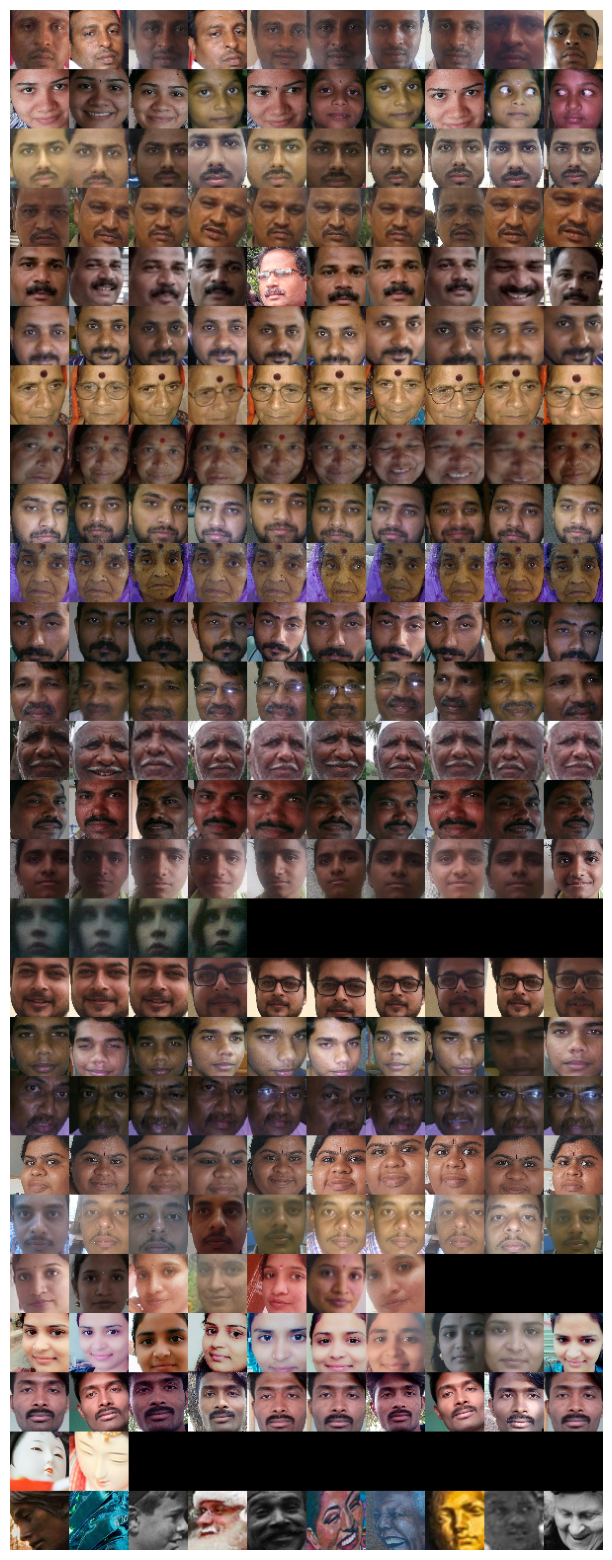

In [30]:
clust.draw(imgs_path="data/clusters", ncols=10)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 596 samples in 0.001s...
[t-SNE] Computed neighbors for 596 samples in 0.097s...
[t-SNE] Computed conditional probabilities for sample 596 / 596
[t-SNE] Mean sigma: 0.164750
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.462151
[t-SNE] KL divergence after 1000 iterations: 0.145790


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


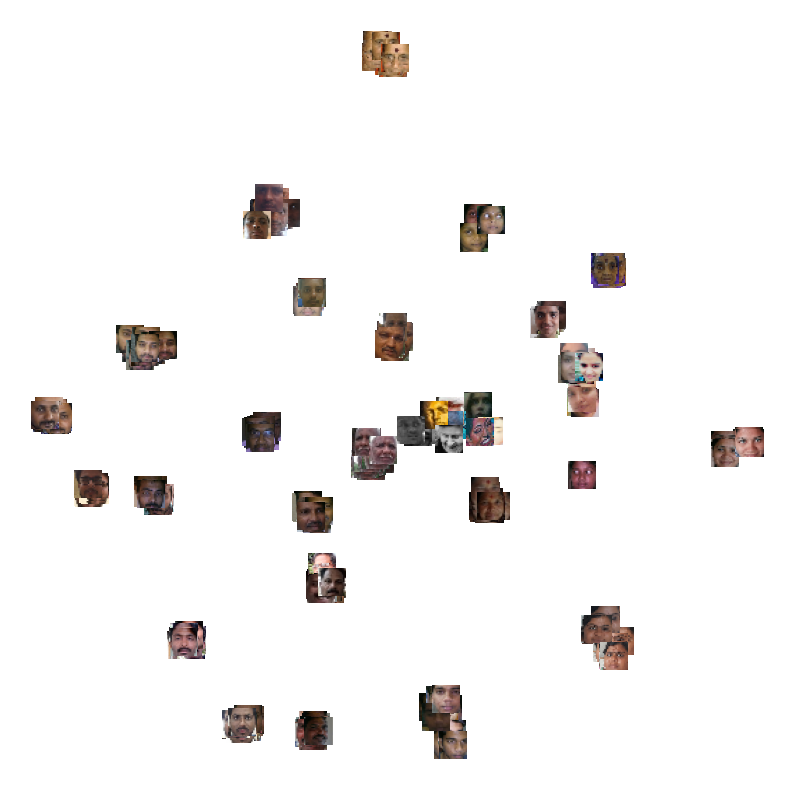

In [29]:
from random import choices
from pathlib import Path
import cv2
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
plt.axis("off")

pca = PCA(n_components=30)
pca_result = pca.fit_transform(clust.x)
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(pca_result)

imgs_path = Path("data/clusters/")
clusters = set(clust.labs_pred)
nclust = len(clusters)
ncols = 10
img_size = (20, 20)

for r in clusters:
    mask = clust.labs_pred == r
    curr_names = [name for m, name in zip(mask, clust.ids) if m][:ncols]
    curr_boxes = [box for m, box in zip(mask, clust.boxes) if m][:ncols]
    curr_xy = [box for m, box in zip(mask, tsne_results) if m][:ncols]
    nshot = 0
    for b, name, xy in zip(curr_boxes, curr_names, curr_xy):
        img_path = imgs_path / name
        x, y = xy#(b[2]+b[0])/2, (b[3]+b[1])/2
        img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        img_crop = img[b[1]:b[3], b[0]:b[2]]
        if min(img_crop.shape) == 0:
            img_crop = img
        img_crop = cv2.resize(img_crop, img_size)
        imbox = OffsetImage(img_crop, zoom=1)
        ab = AnnotationBbox(imbox, (x, y), frameon=False)
        ax.add_artist(ab)
        ax.scatter(x, y);